 **Facial Keypoint Detection**          
 First of all let's discuss what we are given.        
We are given three CSV files.        
training.csv :- Its has coordinates of facial keypoints like left eye, rigth eye etc and also the image.      
test.csv :- Its has image only and we have to give coordinates of various facial keypoints by looking at third csv file which is IdLookupTable.csv     
Rest everything is explained below.      
**I would really appreciate if you could upvote this kernel.**


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
from time import sleep
import os

In [2]:
Train_Dir = '/Users/szkfzx/datasets/FaceDetection/training.csv'
Test_Dir = '/Users/szkfzx/datasets/FaceDetection/test.csv'
lookid_dir = '/Users/szkfzx/datasets/FaceDetection/IdLookupTable.csv'
train_data = pd.read_csv(Train_Dir)  
test_data = pd.read_csv(Test_Dir)
lookid_data = pd.read_csv(lookid_dir)
os.listdir('/Users/szkfzx/datasets/FaceDetection')

['training.csv',
 'IdLookupTable.csv',
 '.DS_Store',
 'SampleSubmission.csv',
 'test.csv']

Lets explore our dataset

In [3]:
train_data.head().T

,0,1,2,3,4
left_eye_center_x,66.0336,64.3329,65.0571,65.2257,66.7253
left_eye_center_y,39.0023,34.9701,34.9096,37.2618,39.6213
right_eye_center_x,30.227,29.9493,30.9038,32.0231,32.2448
right_eye_center_y,36.4217,33.4487,34.9096,37.2618,38.042
left_eye_inner_corner_x,59.5821,58.8562,59.412,60.0033,58.5659
left_eye_inner_corner_y,39.6474,35.2743,36.321,39.1272,39.6213
left_eye_outer_corner_x,73.1303,70.7227,70.9844,72.3147,72.5159
left_eye_outer_corner_y,39.97,36.1872,36.321,38.381,39.8845
right_eye_inner_corner_x,36.3566,36.0347,37.6781,37.6186,36.9824
right_eye_inner_corner_y,37.3894,34.3615,36.321,38.7541,39.0949


Lets check for missing values

In [4]:
train_data.isnull().any().value_counts()

True     28
False     3
dtype: int64

So there are missing values in 28 columns. We can do two things here one remove the rows having missing values and another is the fill missing values with something. I used two option as removing rows will reduce our dataset. 
I filled the missing values with the previous values in that row.

In [5]:
train_data.fillna(method = 'ffill',inplace = True)
#train_data.reset_index(drop = True,inplace = True)

Lets check for missing values now

In [6]:
train_data.isnull().any().value_counts()

False    31
dtype: int64

As there is no missing values we can now separate the labels and features.
The image is our feature and other values are labes that we have to predict later.
As image column values are in string format and there is also some missing values so we have to split the string by space and append it and also handling missing values

In [7]:
imag = []
for i in range(0,7049):
    img = train_data['Image'][i].split(' ')
    img = ['0' if x == '' else x for x in img]
    imag.append(img)

Lets reshape and convert it into float value.

In [8]:
image_list = np.array(imag,dtype = 'float')
X_train = image_list.reshape(-1,96,96)

Lets see what is the first image.

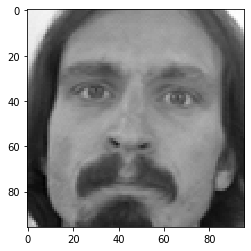

In [9]:
plt.imshow(X_train[0],cmap='gray')
plt.show()

Now lets separate labels.

In [10]:
training = train_data.drop('Image',axis = 1)

y_train = []
for i in range(0,7049):
    y = training.iloc[i,:]

    y_train.append(y)
y_train = np.array(y_train,dtype = 'float')

As our data is ready for training , lets define our model. I am using keras and simple dense layers. For loss function I am using 'mse' ( mean squared error ) as we have to predict new values. Our result evaluted on the basics of 'mae' ( mean absolute error ) . 

In [11]:
from keras.layers import Conv2D,Dropout,Dense,Flatten
from keras.models import Sequential

model = Sequential([Flatten(input_shape=(96,96)),
                         Dense(128, activation="relu"),
                         Dropout(0.1),
                         Dense(64, activation="relu"),
                         Dense(30)
                         ])

model.compile(optimizer='adam', 
              loss='mse',
              metrics=['mae','accuracy'])


Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Now our model is defined and we will train it by calling fit method. I ran it for 500 iteration keeping batch size and validtion set size as 20% ( 20% of the training data will be kept for validating the model ).

In [12]:
model.fit(X_train,y_train,epochs = 500,batch_size = 128,validation_split = 0.2)

Instructions for updating:
Use tf.cast instead.
Train on 5639 samples, validate on 1410 samples
Epoch 1/500
5639/5639 [==============================] - 1s 226us/step - loss: 20092.3932 - mean_absolute_error: 81.0115 - acc: 0.0043 - val_loss: 2710.5329 - val_mean_absolute_error: 48.5385 - val_acc: 0.0000e+00
Epoch 2/500
5639/5639 [==============================] - 1s 139us/step - loss: 2666.7935 - mean_absolute_error: 48.1047 - acc: 0.0000e+00 - val_loss: 2707.6712 - val_mean_absolute_error: 48.5111 - val_acc: 0.0000e+00
Epoch 3/500
5639/5639 [==============================] - 1s 138us/step - loss: 2663.6111 - mean_absolute_error: 48.0732 - acc: 1.7734e-04 - val_loss: 2704.1976 - val_mean_absolute_error: 48.4765 - val_acc: 0.0000e+00
Epoch 4/500
5639/5639 [==============================] - 1s 136us/step - loss: 2660.0731 - mean_absolute_error: 48.0377 - acc: 1.7734e-04 - val_loss: 2700.5468 - val_mean_absolute_error: 48.4401 - val_acc: 0.0000e+00
Epoch 5/500
5639/5639 [================

Epoch 37/500
5639/5639 [==============================] - 1s 138us/step - loss: 2369.2470 - mean_absolute_error: 44.9563 - acc: 0.0000e+00 - val_loss: 2399.3097 - val_mean_absolute_error: 45.2727 - val_acc: 0.0000e+00
Epoch 38/500
5639/5639 [==============================] - 1s 137us/step - loss: 2350.3430 - mean_absolute_error: 44.7519 - acc: 0.0000e+00 - val_loss: 2379.8346 - val_mean_absolute_error: 45.0638 - val_acc: 0.0000e+00
Epoch 39/500
5639/5639 [==============================] - 1s 136us/step - loss: 2330.7046 - mean_absolute_error: 44.5389 - acc: 0.0000e+00 - val_loss: 2359.6284 - val_mean_absolute_error: 44.8462 - val_acc: 0.0000e+00
Epoch 40/500
5639/5639 [==============================] - 1s 137us/step - loss: 2310.3569 - mean_absolute_error: 44.3173 - acc: 0.0000e+00 - val_loss: 2338.7108 - val_mean_absolute_error: 44.6202 - val_acc: 0.0000e+00
Epoch 41/500
5639/5639 [==============================] - 1s 138us/step - loss: 2289.3122 - mean_absolute_error: 44.0872 - acc: 

5639/5639 [==============================] - 1s 139us/step - loss: 1366.0086 - mean_absolute_error: 32.5891 - acc: 0.0000e+00 - val_loss: 1378.6007 - val_mean_absolute_error: 32.7834 - val_acc: 0.0000e+00
Epoch 75/500
5639/5639 [==============================] - 1s 138us/step - loss: 1335.9508 - mean_absolute_error: 32.1535 - acc: 0.0000e+00 - val_loss: 1348.1975 - val_mean_absolute_error: 32.3459 - val_acc: 0.0000e+00
Epoch 76/500
5639/5639 [==============================] - 1s 139us/step - loss: 1306.0189 - mean_absolute_error: 31.7148 - acc: 0.0000e+00 - val_loss: 1317.9423 - val_mean_absolute_error: 31.9055 - val_acc: 0.0000e+00
Epoch 77/500
5639/5639 [==============================] - 1s 139us/step - loss: 1276.2250 - mean_absolute_error: 31.2728 - acc: 0.0000e+00 - val_loss: 1287.8055 - val_mean_absolute_error: 31.4615 - val_acc: 0.0000e+00
Epoch 78/500
5639/5639 [==============================] - 1s 138us/step - loss: 1246.5950 - mean_absolute_error: 30.8280 - acc: 0.0000e+00 - 

Epoch 112/500
5639/5639 [==============================] - 1s 144us/step - loss: 425.2867 - mean_absolute_error: 15.5463 - acc: 1.7734e-04 - val_loss: 428.3140 - val_mean_absolute_error: 15.5798 - val_acc: 0.0000e+00
Epoch 113/500
5639/5639 [==============================] - 1s 145us/step - loss: 408.3099 - mean_absolute_error: 15.1533 - acc: 1.7734e-04 - val_loss: 411.1556 - val_mean_absolute_error: 15.1789 - val_acc: 0.0000e+00
Epoch 114/500
5639/5639 [==============================] - 1s 151us/step - loss: 391.7840 - mean_absolute_error: 14.7649 - acc: 1.7734e-04 - val_loss: 394.4584 - val_mean_absolute_error: 14.7819 - val_acc: 0.0000e+00
Epoch 115/500
5639/5639 [==============================] - 1s 143us/step - loss: 375.7103 - mean_absolute_error: 14.3815 - acc: 1.7734e-04 - val_loss: 378.2034 - val_mean_absolute_error: 14.3884 - val_acc: 0.0000e+00
Epoch 116/500
5639/5639 [==============================] - 1s 144us/step - loss: 360.0771 - mean_absolute_error: 14.0031 - acc: 1.77

5639/5639 [==============================] - 1s 130us/step - loss: 58.6462 - mean_absolute_error: 5.1279 - acc: 1.7734e-04 - val_loss: 56.6149 - val_mean_absolute_error: 4.8798 - val_acc: 0.0000e+00
Epoch 151/500
5639/5639 [==============================] - 1s 133us/step - loss: 55.1197 - mean_absolute_error: 4.9627 - acc: 1.7734e-04 - val_loss: 53.0110 - val_mean_absolute_error: 4.7035 - val_acc: 0.0000e+00
Epoch 152/500
5639/5639 [==============================] - 1s 133us/step - loss: 51.8080 - mean_absolute_error: 4.8029 - acc: 1.7734e-04 - val_loss: 49.6225 - val_mean_absolute_error: 4.5325 - val_acc: 0.0000e+00
Epoch 153/500
5639/5639 [==============================] - 1s 133us/step - loss: 48.6967 - mean_absolute_error: 4.6481 - acc: 1.7734e-04 - val_loss: 46.4339 - val_mean_absolute_error: 4.3662 - val_acc: 0.0000e+00
Epoch 154/500
5639/5639 [==============================] - 1s 139us/step - loss: 45.7742 - mean_absolute_error: 4.4985 - acc: 1.7734e-04 - val_loss: 43.4410 - val

5639/5639 [==============================] - 1s 132us/step - loss: 11.0110 - mean_absolute_error: 2.1979 - acc: 0.3705 - val_loss: 7.1696 - val_mean_absolute_error: 1.7105 - val_acc: 0.3121
Epoch 190/500
5639/5639 [==============================] - 1s 133us/step - loss: 10.8885 - mean_absolute_error: 2.1841 - acc: 0.3705 - val_loss: 7.0225 - val_mean_absolute_error: 1.6936 - val_acc: 0.3121
Epoch 191/500
5639/5639 [==============================] - 1s 132us/step - loss: 10.7797 - mean_absolute_error: 2.1705 - acc: 0.3705 - val_loss: 6.8808 - val_mean_absolute_error: 1.6747 - val_acc: 0.3121
Epoch 192/500
5639/5639 [==============================] - 1s 132us/step - loss: 10.6838 - mean_absolute_error: 2.1585 - acc: 0.3705 - val_loss: 6.7608 - val_mean_absolute_error: 1.6591 - val_acc: 0.3121
Epoch 193/500
5639/5639 [==============================] - 1s 132us/step - loss: 10.5989 - mean_absolute_error: 2.1467 - acc: 0.3705 - val_loss: 6.6430 - val_mean_absolute_error: 1.6416 - val_acc: 0

5639/5639 [==============================] - 1s 145us/step - loss: 10.0536 - mean_absolute_error: 2.0212 - acc: 0.6052 - val_loss: 5.7218 - val_mean_absolute_error: 1.4414 - val_acc: 0.6872
Epoch 230/500
5639/5639 [==============================] - 1s 144us/step - loss: 10.0532 - mean_absolute_error: 2.0216 - acc: 0.6052 - val_loss: 5.7164 - val_mean_absolute_error: 1.4413 - val_acc: 0.6872
Epoch 231/500
5639/5639 [==============================] - 1s 132us/step - loss: 10.0532 - mean_absolute_error: 2.0214 - acc: 0.6052 - val_loss: 5.7135 - val_mean_absolute_error: 1.4396 - val_acc: 0.6872
Epoch 232/500
5639/5639 [==============================] - 1s 134us/step - loss: 10.0532 - mean_absolute_error: 2.0197 - acc: 0.6052 - val_loss: 5.7132 - val_mean_absolute_error: 1.4392 - val_acc: 0.6872
Epoch 233/500
5639/5639 [==============================] - 1s 131us/step - loss: 10.0535 - mean_absolute_error: 2.0179 - acc: 0.6052 - val_loss: 5.6999 - val_mean_absolute_error: 1.4357 - val_acc: 0

5639/5639 [==============================] - 1s 134us/step - loss: 10.0542 - mean_absolute_error: 2.0255 - acc: 0.6052 - val_loss: 5.7241 - val_mean_absolute_error: 1.4459 - val_acc: 0.6872
Epoch 270/500
5639/5639 [==============================] - 1s 130us/step - loss: 10.0537 - mean_absolute_error: 2.0220 - acc: 0.6052 - val_loss: 5.7116 - val_mean_absolute_error: 1.4396 - val_acc: 0.6872
Epoch 271/500
5639/5639 [==============================] - 1s 131us/step - loss: 10.0537 - mean_absolute_error: 2.0180 - acc: 0.6052 - val_loss: 5.6906 - val_mean_absolute_error: 1.4329 - val_acc: 0.6872
Epoch 272/500
5639/5639 [==============================] - 1s 129us/step - loss: 10.0537 - mean_absolute_error: 2.0211 - acc: 0.6052 - val_loss: 5.7144 - val_mean_absolute_error: 1.4412 - val_acc: 0.6872
Epoch 273/500
5639/5639 [==============================] - 1s 130us/step - loss: 10.0535 - mean_absolute_error: 2.0244 - acc: 0.6052 - val_loss: 5.7307 - val_mean_absolute_error: 1.4451 - val_acc: 0

5639/5639 [==============================] - 1s 131us/step - loss: 10.0550 - mean_absolute_error: 2.0157 - acc: 0.6052 - val_loss: 5.6917 - val_mean_absolute_error: 1.4358 - val_acc: 0.6872
Epoch 310/500
5639/5639 [==============================] - 1s 130us/step - loss: 10.0561 - mean_absolute_error: 2.0261 - acc: 0.6052 - val_loss: 5.7261 - val_mean_absolute_error: 1.4398 - val_acc: 0.6872
Epoch 311/500
5639/5639 [==============================] - 1s 131us/step - loss: 10.0542 - mean_absolute_error: 2.0211 - acc: 0.6052 - val_loss: 5.7095 - val_mean_absolute_error: 1.4380 - val_acc: 0.6872
Epoch 312/500
5639/5639 [==============================] - 1s 130us/step - loss: 10.0545 - mean_absolute_error: 2.0224 - acc: 0.6052 - val_loss: 5.6972 - val_mean_absolute_error: 1.4350 - val_acc: 0.6872
Epoch 313/500
5639/5639 [==============================] - 1s 132us/step - loss: 10.0546 - mean_absolute_error: 2.0176 - acc: 0.6052 - val_loss: 5.6951 - val_mean_absolute_error: 1.4352 - val_acc: 0

5639/5639 [==============================] - 1s 131us/step - loss: 10.0559 - mean_absolute_error: 2.0238 - acc: 0.6052 - val_loss: 5.7244 - val_mean_absolute_error: 1.4415 - val_acc: 0.6872
Epoch 350/500
5639/5639 [==============================] - 1s 137us/step - loss: 10.0562 - mean_absolute_error: 2.0222 - acc: 0.6052 - val_loss: 5.7029 - val_mean_absolute_error: 1.4368 - val_acc: 0.6872
Epoch 351/500
5639/5639 [==============================] - 1s 137us/step - loss: 10.0551 - mean_absolute_error: 2.0254 - acc: 0.6052 - val_loss: 5.7135 - val_mean_absolute_error: 1.4353 - val_acc: 0.6872
Epoch 352/500
5639/5639 [==============================] - 1s 139us/step - loss: 10.0547 - mean_absolute_error: 2.0203 - acc: 0.6052 - val_loss: 5.7177 - val_mean_absolute_error: 1.4412 - val_acc: 0.6872
Epoch 353/500
5639/5639 [==============================] - 1s 139us/step - loss: 10.0547 - mean_absolute_error: 2.0173 - acc: 0.6052 - val_loss: 5.6862 - val_mean_absolute_error: 1.4329 - val_acc: 0

5639/5639 [==============================] - 1s 136us/step - loss: 10.0558 - mean_absolute_error: 2.0206 - acc: 0.6052 - val_loss: 5.7583 - val_mean_absolute_error: 1.4550 - val_acc: 0.6872
Epoch 390/500
5639/5639 [==============================] - 1s 138us/step - loss: 10.0564 - mean_absolute_error: 2.0182 - acc: 0.6052 - val_loss: 5.7355 - val_mean_absolute_error: 1.4519 - val_acc: 0.6872
Epoch 391/500
5639/5639 [==============================] - 1s 134us/step - loss: 10.0556 - mean_absolute_error: 2.0256 - acc: 0.6052 - val_loss: 5.6966 - val_mean_absolute_error: 1.4305 - val_acc: 0.6872
Epoch 392/500
5639/5639 [==============================] - 1s 134us/step - loss: 10.0575 - mean_absolute_error: 2.0147 - acc: 0.6052 - val_loss: 5.6585 - val_mean_absolute_error: 1.4247 - val_acc: 0.6872
Epoch 393/500
5639/5639 [==============================] - 1s 142us/step - loss: 10.0567 - mean_absolute_error: 2.0193 - acc: 0.6052 - val_loss: 5.6953 - val_mean_absolute_error: 1.4374 - val_acc: 0

5639/5639 [==============================] - 1s 136us/step - loss: 10.0554 - mean_absolute_error: 2.0163 - acc: 0.6052 - val_loss: 5.6877 - val_mean_absolute_error: 1.4359 - val_acc: 0.6872
Epoch 430/500
5639/5639 [==============================] - 1s 133us/step - loss: 10.0559 - mean_absolute_error: 2.0188 - acc: 0.6052 - val_loss: 5.6504 - val_mean_absolute_error: 1.4217 - val_acc: 0.6872
Epoch 431/500
5639/5639 [==============================] - 1s 131us/step - loss: 10.0550 - mean_absolute_error: 2.0192 - acc: 0.6052 - val_loss: 5.7055 - val_mean_absolute_error: 1.4407 - val_acc: 0.6872
Epoch 432/500
5639/5639 [==============================] - 1s 132us/step - loss: 10.0557 - mean_absolute_error: 2.0175 - acc: 0.6052 - val_loss: 5.6940 - val_mean_absolute_error: 1.4393 - val_acc: 0.6872
Epoch 433/500
5639/5639 [==============================] - 1s 132us/step - loss: 10.0553 - mean_absolute_error: 2.0243 - acc: 0.6052 - val_loss: 5.6519 - val_mean_absolute_error: 1.4194 - val_acc: 0

5639/5639 [==============================] - 1s 137us/step - loss: 10.0566 - mean_absolute_error: 2.0169 - acc: 0.6052 - val_loss: 5.6625 - val_mean_absolute_error: 1.4252 - val_acc: 0.6872
Epoch 470/500
5639/5639 [==============================] - 1s 144us/step - loss: 10.0573 - mean_absolute_error: 2.0245 - acc: 0.6052 - val_loss: 5.6656 - val_mean_absolute_error: 1.4203 - val_acc: 0.6872
Epoch 471/500
5639/5639 [==============================] - 1s 148us/step - loss: 10.0562 - mean_absolute_error: 2.0184 - acc: 0.6052 - val_loss: 5.7267 - val_mean_absolute_error: 1.4467 - val_acc: 0.6872
Epoch 472/500
5639/5639 [==============================] - 1s 139us/step - loss: 10.0561 - mean_absolute_error: 2.0259 - acc: 0.6052 - val_loss: 5.6857 - val_mean_absolute_error: 1.4274 - val_acc: 0.6872
Epoch 473/500
5639/5639 [==============================] - 1s 133us/step - loss: 10.0560 - mean_absolute_error: 2.0175 - acc: 0.6052 - val_loss: 5.6821 - val_mean_absolute_error: 1.4303 - val_acc: 0

Now lets prepare our testing data

In [13]:
#preparing test data
timag = []
for i in range(0,1783):
    timg = test_data['Image'][i].split(' ')
    timg = ['0' if x == '' else x for x in timg]
    
    timag.append(timg)

Reshaping and converting 

In [14]:
timage_list = np.array(timag,dtype = 'float')
X_test = timage_list.reshape(-1,96,96)

Lets see first image in out test data

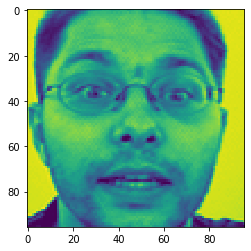

In [15]:
plt.imshow(X_test[0])
plt.show()

Lets predict our results

In [16]:
pred = model.predict(X_test)

Now the last step is the create our submission file keeping in the mind required format.
There should be two columns :- RowId and Location
Location column values should be filled according the lookup table provided ( IdLookupTable.csv)


In [17]:
lookid_list = list(lookid_data['FeatureName'])
imageID = list(lookid_data['ImageId']-1)
pre_list = list(pred)

In [18]:
rowid = lookid_data['RowId']
rowid=list(rowid)

In [19]:
feature = []
for f in list(lookid_data['FeatureName']):
    feature.append(lookid_list.index(f))

In [20]:
preded = []
for x,y in zip(imageID,feature):
    preded.append(pre_list[x][y])

In [21]:
rowid = pd.Series(rowid,name = 'RowId')

In [22]:
loc = pd.Series(preded,name = 'Location')

In [23]:
submission = pd.concat([rowid,loc],axis = 1)

In [24]:
submission.to_csv('face_key_detection_submission.csv',index = False)

In [25]:
submission

,RowId,Location
0,1,66.343742
1,2,37.557144
2,3,30.192181
3,4,37.879425
4,5,59.213432
5,6,36.845161
6,7,73.693100
7,8,35.890125
8,9,37.150784
9,10,38.781727
